# Analyse de commentaires YouTube

Projet Python de deuxième année à l'ENSAE Paris.

Antoine Lelong, Louisa Camadini, Yseult Masson

# Introduction

Les commentaires postés sous les vidéos YouTube sont une source d'information, complémentaire avec les "likes", pour les créateurs de contenu. Ils permettent au vidéaste de déterminer si son travail a plu ou non à son audience. Cependant, les Youtubeurs n'ont pas nécessairement le temps de tous les lire. Il nous a donc semblé intéressant d'analyser ces commentaires informatiquement, plutôt que de les traiter un à un.

Pour ce projet, nous nous sommes penchés sur la chaîne YouTube DirtyBiology, qui fait de la vulgarisation scientifique. Notre choix a été motivé par le fait que les commentaires sous de telles vidéos étaient à la fois nombreux (car la chaîne est relativement connue), constructifs (de par le contenu scientifique) et sans trop de fautes d'ortographes. Cela nous permettait d'avoir des données exploitables pour l'analyse que nous voulions en faire.

In [1]:
#!pip install -r requirements.txt

In [2]:
# Import des modules utiles

from googleapiclient.discovery import build
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 1 - Webscraping, création et nettoyage de la base de données (Antoine)

## 1.1 - Webscraping

Dans un premier temps, nous avons utilisé [l'API YouTube Data](https://developers.google.com/youtube/v3), qui nous permet de récupérer les 100 commentaires les plus "pertinents" d'une vidéo, sur jusqu'à 20 vidéos différentes, constituant ainsi une base de données de 2000 commentaires, ainsi que quelques données supplémentaires, comme le nombre de likes, le nom d'utilisateur...  
Le script scraper.py va chercher ces données et les stocke dans le fichier comments.csv  
Les API Google fonctionnent avec des clés d'identification confidentielles, qui n'apparaissent par conséquent pas dans le dépot github. Pour faire fonctionner le script correctement, il faut créer un fichier s'apppelant ".env" et y placer la ligne suivante :  
`APIKEY="identifiant_de_la_clé"`

In [3]:
#!python scraper.py

## 1.2 - Nettoyage de la base de données

Le script cleaning est prépare les commentaires aux applications des autres parties, en retirant les majuscules, sauts de lignes...

In [4]:
#!python cleaning.py

In [45]:
data = pd.read_csv("comments.csv")
data.head(3)

,videoId,textDisplay,textOriginal,authorDisplayName,authorProfileImageUrl,authorChannelUrl,authorChannelId,canRate,viewerRating,publishedAt,updatedAt,commentLikeCount,viewCount,commentCount,videoLikeCount,videoTitle,videoDate,textClean
0,EfH0oscLFhk,Du coup peut on dire qu’on a encore plus de ch...,Du coup peut on dire qu’on a encore plus de ch...,Minx,https://yt3.ggpht.com/ytc/AKedOLQAMtKSrCPfkjfg...,http://www.youtube.com/channel/UCm1YdSnO2Y7vuw...,UCm1YdSnO2Y7vuwTr6yTKwAw,True,none,2022-01-01T17:22:33Z,2022-01-01T17:22:33Z,1023,388701,849,34914,La vie est-elle un (gros) coup de chance ? - D...,2022-01-01T17:18:55Z,du coup peut on dire qu’on a encore plus de ch...
1,EfH0oscLFhk,"J&#39;ai eu ton livre à Noël, il est incroyabl...","J'ai eu ton livre à Noël, il est incroyable, m...",Maxime ',https://yt3.ggpht.com/ytc/AKedOLRol_dSsQ7cG04a...,http://www.youtube.com/channel/UCeoRNNIN1PVzIh...,UCeoRNNIN1PVzIhhoxhSDv6g,True,none,2022-01-01T17:24:31Z,2022-01-01T17:24:31Z,364,388701,849,34914,La vie est-elle un (gros) coup de chance ? - D...,2022-01-01T17:18:55Z,"j'ai eu ton livre à noël, il est incroyable, m..."
2,EfH0oscLFhk,"Ton livre a Noël, meilleur cadeau ! Merci 😊","Ton livre a Noël, meilleur cadeau ! Merci 😊",Light,https://yt3.ggpht.com/8Z5CHat3_hAP1fIOHdEasFFD...,http://www.youtube.com/channel/UCdg5gH0YGsCA3T...,UCdg5gH0YGsCA3ThvnFE4jUw,True,none,2022-01-03T12:12:39Z,2022-01-03T12:12:39Z,9,388701,849,34914,La vie est-elle un (gros) coup de chance ? - D...,2022-01-01T17:18:55Z,"ton livre a noël, meilleur cadeau ! merci 😊"


# 2 - Analyse des commentaires
## 2.1 - Analyse exploratoire quantitative

Par simplicité, on remplace les identifiants de vidéo par des numéros dans l'ordre de publication (1 pour la plus ancienne, 20 pour la dernière)

In [46]:
dico = {data.videoId.unique()[i] : 20- i for i in range(len(data.videoId.unique()))}
data['videoId']=data['videoId'].replace(to_replace=dico)
data.sample(3)

,videoId,textDisplay,textOriginal,authorDisplayName,authorProfileImageUrl,authorChannelUrl,authorChannelId,canRate,viewerRating,publishedAt,updatedAt,commentLikeCount,viewCount,commentCount,videoLikeCount,videoTitle,videoDate,textClean
1243,8,"Merci à toi, t&#39;as fait un sacré travail de...","Merci à toi, t'as fait un sacré travail de rec...",łîšą_ Henard-B,https://yt3.ggpht.com/ytc/AKedOLQ6dqinUArQA1dg...,http://www.youtube.com/channel/UCklVascAEm92W2...,UCklVascAEm92W2qiAVEsh8Q,True,none,2021-02-17T21:43:59Z,2021-02-17T21:43:59Z,0,790036,2601,77143,Vous ne savez pas à quoi ressemble le monde vi...,2021-01-20T11:52:48Z,"merci à toi, t'as fait un sacré travail de rec..."
672,14,La notification qui fait toujours très plaisir...,La notification qui fait toujours très plaisir...,RoisorcierPilou,https://yt3.ggpht.com/ytc/AKedOLRBAlJ0PaAhP0Zo...,http://www.youtube.com/channel/UCFNDOC9I8dZZGx...,UCFNDOC9I8dZZGxiUmGByzJg,True,none,2021-07-22T18:45:16Z,2021-07-22T18:45:16Z,0,431267,1121,40049,Cet oiseau prédira les catastrophes ? (expédit...,2021-07-22T13:47:59Z,la notification qui fait toujours très plaisir...
1838,2,La vidéo : On a craqué sur le montage.<br>Moi ...,La vidéo : On a craqué sur le montage.\nMoi : ...,Beleon Juss'Nest,https://yt3.ggpht.com/ytc/AKedOLTjnyxXpvPo54r6...,http://www.youtube.com/channel/UCI5aJs5tpi4lej...,UCI5aJs5tpi4lejPFCgNgOmg,True,none,2020-06-27T17:24:12Z,2020-06-27T17:24:12Z,864,815210,3970,75556,Comment créer une couleur ? - DBY #69,2020-06-27T17:02:26Z,la vidéo : on a craqué sur le montage.\nmoi : ...


Certaines données caractérisent la vidéo et non le commentaire, on les récupère dans une autre DataFrame. Elles sont égales sur une vidéo, donc égales à leur max sur ces groupes :

In [47]:
info_video = data.groupby('videoId')[['viewCount', 'commentCount', 'videoLikeCount','videoDate']].max()
info_video['likePerView'] = info_video['videoLikeCount']/info_video['viewCount']
info_video['Engagement'] = info_video['commentCount']/info_video['viewCount']
info_video.tail(3)

,viewCount,commentCount,videoLikeCount,videoDate,likePerView,Engagement
videoId,,,,,,
18,793269,2551,55911,2021-11-01T13:40:00Z,0.070482,0.003216
19,418526,795,37787,2021-12-12T13:00:37Z,0.090286,0.001900
20,388701,849,34914,2022-01-01T17:18:55Z,0.089822,0.002184


On crée une variable correspondant au nombre de mois entre la publication de la vidéo et celle de la dernière vidéo de la base de données :

In [49]:
nbr_mois = lambda date : 25 - (int(date[5:7])+12*int(date[3]))
info_video['ancienneté'] = info_video.videoDate.apply(nbr_mois)
info_video.head(3)

,viewCount,commentCount,videoLikeCount,videoDate,likePerView,Engagement,ancienneté
videoId,,,,,,,
1,1409977,3674,95877,2020-04-23T16:08:22Z,0.067999,0.002606,21
2,815210,3970,75556,2020-06-27T17:02:26Z,0.092683,0.004870,19
3,1229621,8193,100902,2020-07-23T10:58:44Z,0.082059,0.006663,18


No handles with labels found to put in legend.


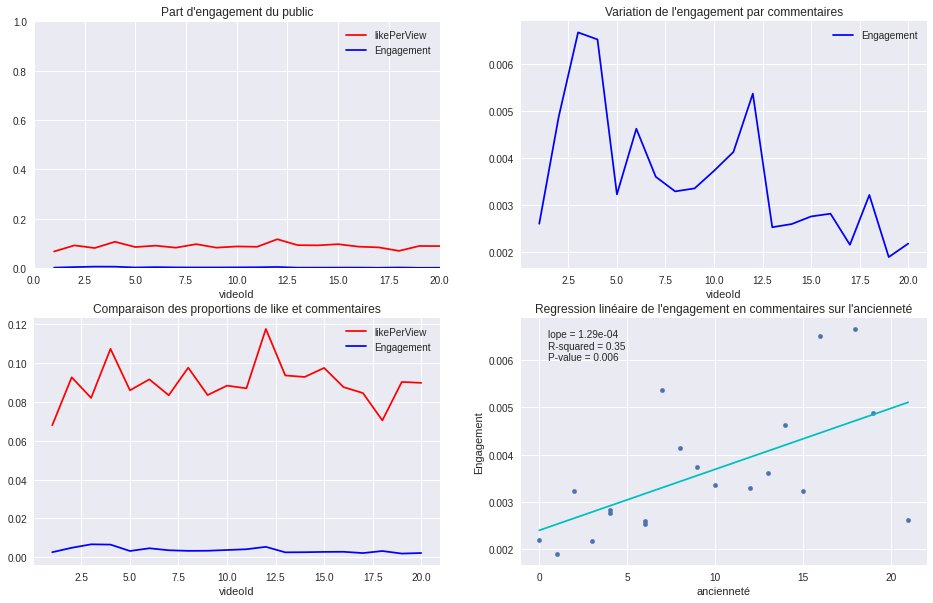

In [50]:
from scipy.stats import linregress

plt.style.use('seaborn')

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

info_video.plot(y='likePerView', ax=axs[0][0], color='r')
info_video.plot(y='Engagement', ax=axs[0][0], color='b')
axs[0][0].axis([0,20,0,1])
axs[0][0].set_title("Part d'engagement du public")

info_video.plot(y='likePerView', ax=axs[1][0], color='r')
info_video.plot(y='Engagement', ax=axs[1][0], color='b')
axs[1][0].set_title("Comparaison des proportions de like et commentaires")

info_video.plot(y='Engagement', ax=axs[0][1], color='b')
axs[0][1].set_title("Variation de l'engagement par commentaires")


slope, intercept, r_value, p_value, std_err = linregress(x=info_video.ancienneté, y=info_video.Engagement)

info_video.plot.scatter(x='ancienneté', y='Engagement', ax=axs[1][1])
axs[1][1].plot(info_video.ancienneté, slope*info_video.ancienneté + intercept, color='c')
axs[1][1].set_title("Regression linéaire de l'engagement en commentaires sur l'ancienneté")
plt.text(x=0.5, y=0.006, s=f"lope = {slope:.2e}\nR-squared = {r_value**2:.2f} \nP-value = {p_value:.3f}")
plt.legend()


plt.show()


Comme on peut le voir, la part de viewers qui 'likent' et commentent reste stable autour de 9% et 0.4% respectivement, soit une minorité de la totalité des viewers.  
On remarque une tendance d'augmentation de la proportion de viewers qui commentent avec l'ancienneté de la vidéo, ce qui suggère que les personnes qui regardent la vidéo tard on plus tendance à commenter. L'interprétation de la régression linéaire donne que pour chaque mois qui passe, cette proportion augmente en moyenne de 0.001 (pour rappelle, elle varie aux alentours de 0.004 sur les observations). La P-valeur à 0.006 montre que le coefficient de la courbe est significatif au seuil 1%. 

## 2.2 - Thèmes majoritairement abordés dans les commentaires (Louisa)

Imports nécessaires pour cette partie

In [72]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('genesis')
nltk.download('wordnet')

### Tokenisation

On voit que l'on va s'intéresser ici à la colonne `'textClean'` qui a été nettoyée au préalable. Chaque ligne du dataframe représente un commentaire. L'ensemble de ces lignes, c'est-à-dire tous les commentaires, correspondent donc à notre texte d'étude. Il s'agit tout d'abord de décomposer le texte en unités lexicale, afin de pouvoir analyser les impressions laissées en commentaire.

In [62]:
content = " ".join(data['textClean'])

words = nltk.word_tokenize(content, language='french')
#words[200:250]

La texte a bien été décomposé en 'tokens', mais ce ne sont pas tous des mots : certains peuvent être des signes de ponctuation, des smileys... 
La méthode `isalpha()` renvoie "True" si tous les caractères de la chaîne sont des alphabets, on l'utilise pour ne garder que les 'tokens' qui sont des mots.

In [63]:
words = [word for word in words if word.isalpha()]
#words[200:250]

Maintenant, certains mots comme les déterminants, pronoms, sont répétitifs et inutiles à l'analyse du texte. On supprime donc ce qu'on appelle les 'stopwords' :

In [68]:
stop_words = set(stopwords.words('french'))

words = [w for w in words if not w in stop_words]
print(words[200:250])

['toujours', 'plus', 'qualitatives', 'pédagogique', 'toujours', 'superbes', 'vidéo', 'passionnant', 'mec', 'montage', 'malade', 'rend', 'tout', 'léger', 'digeste', 'bien', 'joué', 'incroyable', 'retrouver', 'telles', 'notions', 'physique', 'coût', 'énergie', 'création', 'surface', 'vidéos', 'bisous', 'livre', 'a', 'noël', 'meilleur', 'cadeau', 'merci', 'old', 'boy', 'manga', 'a', 'base', 'assez', 'incroyable', 'a', 'lire', 'bien', 'aimé', 'montage', 'droite', 'gauche', 'imagine', 'chance']


### Création de WordClouds

Ils permettent de synthétiser les mots et expressions qui reviennent le plus couramment dans les commentaires, et l'on voit qu'ils sont plutôt positifs pour la chaine DirtyBiology !
Les images suivantes sont disponibles dans l'onglet [graphes](https://github.com/taucmar/projet-python-2a/tree/main/graphs) de notre dépôt GitHub.

In [80]:
text = " ".join(words)

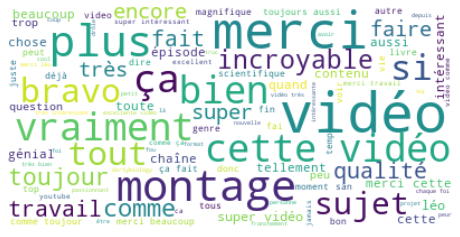

In [82]:
# Generate a wordcloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

On a ici généré un premier nuage de points classique, composé de 100 mots qui semblent positifs dès le premier coup d'œil : vidéo, travail, merci, incroyable , bravo, intéressant...  
On customise ce nuage de mots en l'intégrant au logo YouTube

In [75]:
mask = np.array(Image.open("mask.png"))

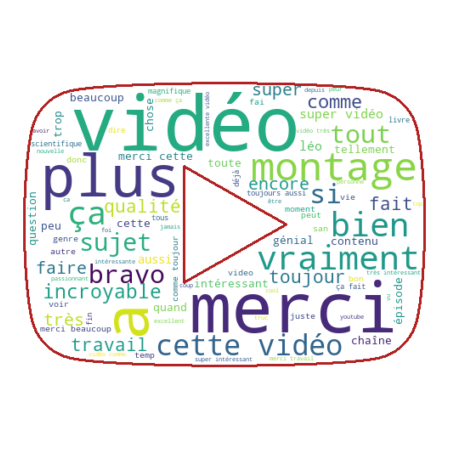

In [87]:
# Create a word cloud image
wc = WordCloud(background_color="white", max_words=90, mask=mask,
               stopwords=stop_words, contour_width=3, contour_color='firebrick')

# Generate a wordcloud
wc.generate(text)

# Store to file
wc.to_file("./graphs/logo_youtube.png")

# Show
plt.figure(figsize=[10,8])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Mieux encore, on peut utiliser le logo de DirtyBiology, en retravaillant des images trouvées sur [Internet](https://www.pinterest.fr/pin/148689225175699166/).

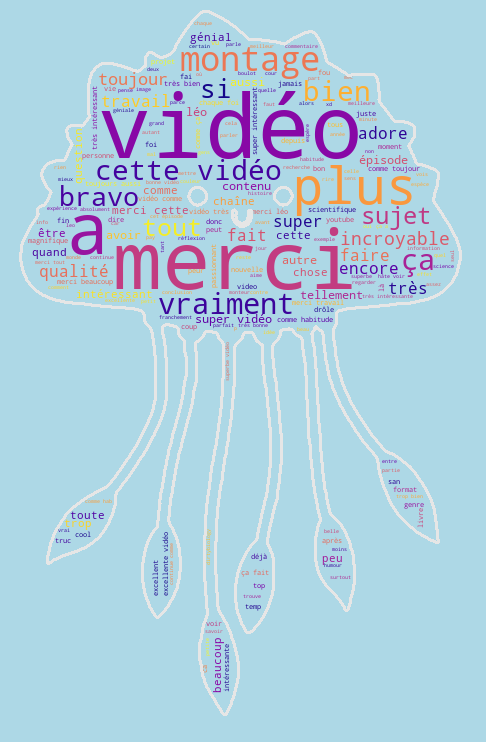

In [89]:
from IPython.display import Image
Image("./graphs/logo_dirty_bio.png")

## 2.3 - Polarisation des commentaires (Yseult)

### 2.3.1 - Calcul de polarités

Le module TextBlob est un module python de NLP utilisé pour l'analyse de sentiments et qui permet, entre autres, de calculer la polarité d'un texte. Celle-ci est définie par un nombre entre -1 et 1, et détermine le degré de satisfaction ou d'insatisfaction qui se dégage du texte. Plus la polaritée est proche de 1, plus le texte dégage un sentiment positif, et vice-versa.

Nous avons calculé la polarité de chaque commentaire de deux façons. Nous avons d'une part appliqué directement la fonction du module TextBlob qui nous intéresse au commentaire. D'autre part, nous avons découpé chaque commentaire en phrases, avant d'appliquer à chacune de celles-ci la fonction qui renvoie leur polarisation, puis d'en faire la moyenne sur toutes les phrases du commentaire.

In [104]:
def blober(text: str) -> float:
    '''
    Calcule la polarité d'un texte.
    
    Paramètres : 
    ----------
    text : str
        texte dont on veut mesurer la polarité
        
    Sortie :
    ----------
    float
        polarisation : score entre -1 et 1.
        Plus le score est proche de 1, plus le commentaire est positif.
        Plus il est proche de -1, plus le commentaire est négatif.
    '''
    return TextBlob(text, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment[0]

blober = np.vectorize(blober)

def sentences(comment: str) -> list:
    '''
    Découpe un texte en phrases.
    
    Paramètres : 
    ----------
    comment : str
        texte dont on veut extraire les phrases
        
    Sortie :
    ----------
    list[str]
        liste des phrases du texte
    '''
    tokenizer = nltk.data.load('tokenizers/punkt/french.pickle')
    return tokenizer.tokenize(comment)

def polarisation(comment: str) -> float:
    '''
    Calcule la polarisation d'un commentaire en calculant d'abord la polarisation de chacune de ses 
    phrases et en en faisant la moyenne
    
    Paramètres : 
    ----------
    comment : str
        texte dont on veut la polarisation
        
    Sortie :
    ----------
    float
        moyenne des polarisations des phrases du texte
    '''
    s = sentences(comment)
    return np.mean(blober(s))

polarisation = np.vectorize(polarisation)

Nous avons ensuite ajouté 2 nouvelles colonnes à la base de données:

   - Polarity : polarité de chaque commentaire, calculée sur le commentaire entier directement
    
   - sentencesPolarity : polarité de chaque commentaire, calculée en prenant la moyenne des polarités sur chaque phrase que comporte le commentaire.

In [105]:
data["Polarity"] = data.loc[:,['textClean']].apply(blober)
data["sentencesPolarity"] = data.loc[:,['textClean']].apply(polarisation)

Création d'une colonne de numéros des vidéos (ici ou partie 1)

In [106]:
data['DBY'] = data.loc[:,['videoTitle']].apply(np.vectorize(lambda string : string[-7:]))

### 2.3.2 Analyse des polarités

Dans un premier temps, on s'intéresse à la répartition des polarités pour une vidéo, ici la vidéo "Comment ces champis nous ont façonnés - DBY #76".

In [107]:
data.loc[data['DBY'] == "DBY #76", ['Polarity', 'sentencesPolarity']].describe()

,Polarity,sentencesPolarity
count,100.000000,100.000000
mean,0.358376,0.308844
std,0.291595,0.259852
min,-0.200000,-0.106000
25%,0.145833,0.121979
50%,0.343125,0.252500
75%,0.499766,0.450833
max,1.000000,1.000000


On voit que pour les deux types de polarité, il y a très peu de valeurs négatives. Cela implique que les commentaires de cette vidéo sont pour la plupart perçus comme positifs.
Les écarts type sont de 0.29 et 0.26, ce qui est assez élevé pour des valeurs de polarités allant entre -0.2 (-0.1 pour "sentencesPolarity") et 1. Ainsi, les commentaires de cette vidéo dégagent plusieurs degrés de satisfaction, allant de neutre à très satisfait. La moitié d'entre eux sont relativement satisfaits, et ont une polarité se trouvant entre 0.15 et 0.50 (0.12 et 0.45 pour sentencesPolarity).

Cela se perçoit bien sur les histogrammes ci-dessous:

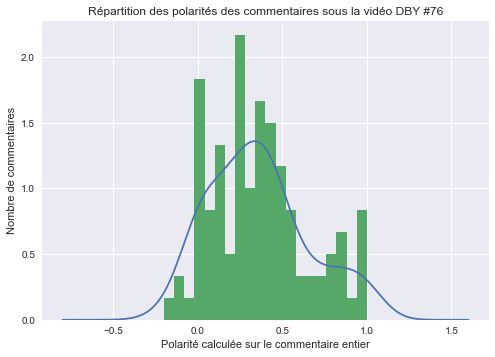

In [120]:
data.loc[data['DBY'] == "DBY #76", 'Polarity'].plot.density()
data.loc[data['DBY'] == "DBY #76", 'Polarity'].plot.hist(bins=20, density=True)

plt.xlabel("Polarité calculée sur le commentaire entier")
plt.ylabel("Nombre de commentaires")
plt.title("Répartition des polarités des commentaires sous la vidéo DBY #76")
plt.show()

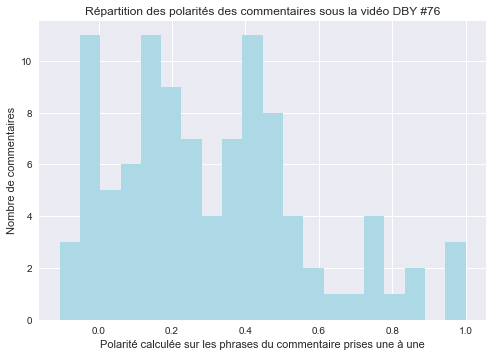

In [121]:
plt.hist(data.loc[data['DBY'] == "DBY #76", 'sentencesPolarity'], bins = 20, color = 'lightblue')
plt.xlabel("Polarité calculée sur les phrases du commentaire prises une à une")
plt.ylabel("Nombre de commentaires")
plt.title("Répartition des polarités des commentaires sous la vidéo DBY #76")
plt.show()

Nous avons ensuite fait la moyenne des polarités sur les 100 commentaires de chaque vidéo, ce qui nous permet de comparer les vidéos entre elles.

In [7]:
datapol = data.groupby(['DBY']).mean().sort_values('Polarity', ascending = False)
datapol.loc[:, ['videoLikeCount', 'Polarity', 'sentencesPolarity']]

,videoLikeCount,Polarity,sentencesPolarity
DBY,,,
DBY #72,87989.0,0.391309,0.378558
DBY #81,40049.0,0.389876,0.322359
DBY #74,50143.0,0.374054,0.324198
DBY #80,42476.0,0.363191,0.331241
DBY #76,47150.0,0.358376,0.308844
DBY#84,49593.0,0.353083,0.297797
DBY #77,62565.0,0.339487,0.299937
DBY #87,34479.0,0.338270,0.295363
DBY #82,46056.0,0.334684,0.296303


Tout d'abord, nous avons cherché à savoir si les résultats de polarisation restaient cohérents entre les deux méthodes utilisées.

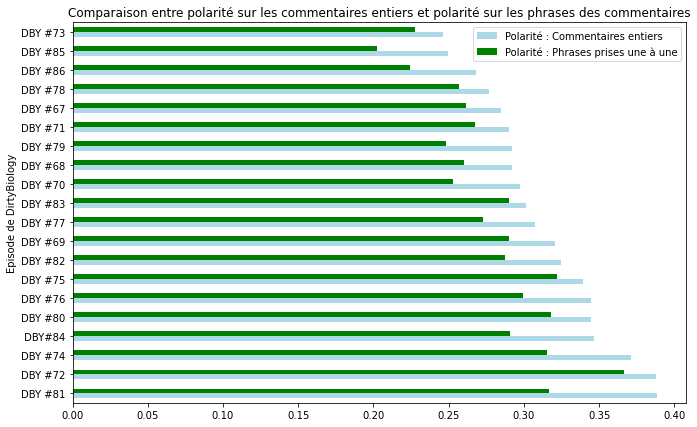

In [14]:
datapol.loc[:,['Polarity','sentencesPolarity']].plot(kind = 'barh', figsize = (11, 7), color = ['lightblue', 'green'], title = 'Comparaison entre polarité sur les commentaires entiers et polarité sur les phrases des commentaires', xlabel = 'Episode de DirtyBiology')
plt.legend(labels = ['Polarité : Commentaires entiers', 'Polarité : Phrases prises une à une'])
plt.show()

L'ordre des vidéos change un peu selon la définition que l'on utilise pour la polarité, mais les deux définitions semblent tout de même corrélées (globalement, la polarité prise sur chaque phrase augmente avec celle prise sur le commentaire entier).

Dans la suite, on garde la polarité sur le commentaire entier.

La polarité est un témoin du succès qu'a eu une vidéo. On cherche à présent à la comparer à un autre marqueur de ce succès, à savoir le ratio de "likes" qu'à reçu une vidéo par rapport à son nombre de vues.

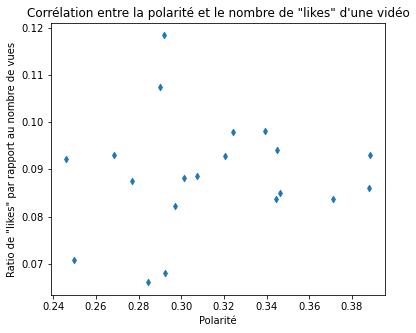

In [9]:
datapol['likeRatio'] = datapol.loc[:,'videoLikeCount'].divide(datapol.loc[:,'viewCount'])
datapol.plot(kind = 'scatter', x = 'Polarity', y = 'likeRatio',figsize = (6, 5), marker = 'd', xlabel = 'Polarité', ylabel = 'Ratio de \"likes\" par rapport au nombre de vues', title = 'Corrélation entre la polarité et le nombre de \"likes\" d\'une vidéo')
plt.show()

Il semble ne pas y avoir de corrélation entre ces deux marqueurs. Cela peut être dû au fait que la polarisation ne soit pas très précise, ou que les personnes qui commentent les vidéos n'aient pas le même profil que ceux qui se contentent de "liker".

## 2.3 - Analyse en composantes principales

Dans cette partie, nous utilisons la bibliothèque [Sentence Transformer](https://github.com/UKPLab/sentence-transformers) pour transformer les phrases en vecteurs réels. Cela nous permet ensuite de faire une ACP, pour visualiser les différences entre les commentaires, et étudier les plus extrêmes, puisque l'ACP conserve un maximum de variance.

In [125]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer

La première étape est de préparer l'encoding :
1. On récupère les commentaires
2. On isole le texte du reste de la base de données
3. Dans la liste font, on fait correspondre à chaque indice de commentaire le numéro de la vidéo associée (pour faire des catégories dans l'ACP)

In [130]:
st = SentenceTransformer("xlm-r-bert-base-nli-stsb-mean-tokens")
data = pd.read_csv("./comments.csv")

comments = data[['textClean', 'videoId']]

text = comments["textClean"].values.tolist()

dico_font_video = {}

for i, videoid in enumerate(comments.videoId.unique()):
    dico_font_video[videoid] = i

font = [dico_font_video[videoid] for videoid in comments.videoId]

On peut ensuite encoder le texte, ce qui les transforme en vecteurs de $\mathbb{R}^{768}$, qu'on projette après dans $\mathbb{R}^{2}$ :

In [ ]:
embs = st.encode(text)
pca = PCA(2).fit_transform(embs)

Pour une première visualisation, on réunit les commentaires par clusters (dans R^768), et on utilise ces catégories lorsqu'on affiche sur l'ACP dans R^2. On récupère aussi les commentaires les plus proches des centroïdes afin d'avoir des commentaires "représentants".

In [ ]:
center_indices = [
    int(np.argmin([np.sum((x-centroid)**2) for x in embs]))
    for centroid in kmeans.cluster_centers_]

commentaires_representants = [comments.textClean[i] for i in center_indices]
representants = ''
for i, comment in enumerate(commentaires_representants):
    representants += f'{i}:{comment} \n'
print(representants)